# AirBnB Fair Valuation - scikit-learn

The task of this project is to set the competitive **daily accomodation rate** for a client's house in Bondi Beach.  

In this project, I will estimate a **fair value** that the owner should be charging. The model - which will essentially be a recommendation model - will estimate the fair value of any property on the AirBnB database.

The dataset is available here: https://www.kaggle.com/tylerx/sydney-airbnb-open-data?select=listings_dec18.csv

The new clients house has the following characteristics and constraints:

1. The owner has been a host since **August 2010**
1. The location is **lon:151.274506, lat:33.889087**
1. The current review score rating **95.0**
1. Number of reviews **53**
1. Minimum nights **4**
1. The house can accomodate **10** people.
1. The owner currently charges a cleaning fee of **370**
1. The house has **3 bathrooms, 5 bedrooms, 7 beds**.
1. The house is available for **255 of the next 365 days**
1. The client is **verified**, and they are a **superhost**.
1. The cancelation policy is **strict with a 14 days grace period**.
1. The host requires a security deposit of **$1,500**

*All values strictly apply to the month of Dec 2018*.

The owner currently charges **$500**. Are they under or over selling? What should they charge?

# Setup

In [1]:
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
pd.options.display.max_columns = None

# Get the data

In [2]:
df = pd.read_csv('kaggle_AirBnB/listings_dec18.csv')

D:\Anaconda\envs\pytorchenv\lib\site-packages\IPython\core\interactiveshell.py:3173: DtypeWarning: Columns (43,61,62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# select only relavent data
incl = ["price","city","longitude","latitude","review_scores_rating","number_of_reviews","minimum_nights","security_deposit","cleaning_fee",
        "accommodates","bathrooms","bedrooms","beds","property_type","room_type","availability_365" ,"host_identity_verified", 
        "host_is_superhost","host_since","cancellation_policy"] 

df = df[incl]

In [4]:
df.head()

price           city   longitude   latitude  review_scores_rating  \
0  $100.00        Pyrmont  151.191896 -33.865153                  95.0   
1  $471.00      Balgowlah  151.261722 -33.800929                 100.0   
2  $109.00   Darlinghurst  151.216541 -33.880455                  88.0   
3  $450.00        Balmain  151.172753 -33.859072                  96.0   
4   $62.00  Bellevue Hill  151.259404 -33.889087                  94.0   

   number_of_reviews  minimum_nights security_deposit cleaning_fee  \
0                493               2            $0.00       $55.00   
1                  1               5          $900.00      $100.00   
2                300               2              NaN          NaN   
3                 15               7          $800.00          NaN   
4                 42               1            $0.00       $25.00   

   accommodates  bathrooms  bedrooms  beds property_type        room_type  \
0             2        1.0       1.0   1.0     Townhouse     Private room   
1             6        3.0       3.0   3.0         House  Entire home/apt   
2             2        1.0       1.0   1.0     Apartment     Private room   
3             8        2.0       4.0   4.0         House  Entire home/apt   
4             2        1.0       1.0   1.0     Apartment     Private room   

   availability_365 host_identity_verified host_is_superhost  host_since  \
0               187                      t                 f  2009-05-14   
1               321                      t                 f  2009-11-20   
2               316                      t                 f  2009-12-03   
3                69                      t                 t  2009-12-19   
4               140                      t                 f  2010-04-19   

           cancellation_policy  
0  strict_14_with_grace_period  
1  strict_14_with_grace_period  
2  strict_14_with_grace_period  
3  strict_14_with_grace_period  
4                     moderate

In [5]:
# reformat original data and paste as new csv
df.to_csv('airbnb.csv')

In [6]:
df.shape

(36662, 20)

# Data Preprocessing

#### Reformat datatypes for price and dates

In [7]:
# Importing regex
import re

# The price fields in our data frame
price_list = ["price","cleaning_fee","security_deposit"]

# We change any blanks to 0 and use our regex function to remove anything that isn't a number (or negative number which is changed to 0)
for col in price_list:
    df[col] = df[col].fillna("0")
    df[col] = df[col].apply(lambda x: float(re.compile('[^0-9eE.]').sub('', x)) if len(x)>0 else 0)

df['host_since'] = pd.to_datetime(df['host_since'])

In [8]:
#check new datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36662 entries, 0 to 36661
Data columns (total 20 columns):
price                     36662 non-null float64
city                      36633 non-null object
longitude                 36662 non-null float64
latitude                  36662 non-null float64
review_scores_rating      23536 non-null float64
number_of_reviews         36662 non-null int64
minimum_nights            36662 non-null int64
security_deposit          36662 non-null float64
cleaning_fee              36662 non-null float64
accommodates              36662 non-null int64
bathrooms                 36643 non-null float64
bedrooms                  36653 non-null float64
beds                      36623 non-null float64
property_type             36662 non-null object
room_type                 36662 non-null object
availability_365          36662 non-null int64
host_identity_verified    36656 non-null object
host_is_superhost         36656 non-null object
host_since            

#### Check for null data

In [9]:
# Check data for null values
df.isnull().sum()

price                         0
city                         29
longitude                     0
latitude                      0
review_scores_rating      13126
number_of_reviews             0
minimum_nights                0
security_deposit              0
cleaning_fee                  0
accommodates                  0
bathrooms                    19
bedrooms                      9
beds                         39
property_type                 0
room_type                     0
availability_365              0
host_identity_verified        6
host_is_superhost             6
host_since                    6
cancellation_policy           0
dtype: int64

We have lots of null values in 'review_scores_rating'

#### Check data/price distributions and process accordingly

15.29134068605591

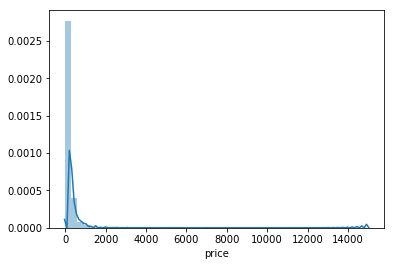

In [10]:
## Plot distribution and check for high price outliers and skew in prices
sns.distplot(df["price"])

df["price"].skew()

Some high prices but the majority are low priced

In [11]:
## Now we filter out high value 'outliers'. We'll consider taking the 99.5% percentile and exclude the bottom .25% and top .25% of prices
print(df["price"].quantile(0.995))
print(df["price"].mean())
print(df["price"].median())

1696.949999999997
207.6895968577819
136.0


In [12]:
# Remove all prices outside the 99.5% percentile 
df = df[df["price"]<df["price"].quantile(0.995)].reset_index(drop=True)

In [13]:
# The skew should now reduce
df["price"].skew()

3.030610547713422

#### Encode host details with binary representation

In [14]:
##  encode binary 1, 0 for t and f. 
df["host_identity_verified"] = df["host_identity_verified"].apply(lambda x: 1 if x=="t" else 0)
df["host_is_superhost"] = df["host_is_superhost"].apply(lambda x: 1 if x=="t" else 0)

#### Reduce down to top 20 

In [15]:
## Now let's focus on the top 20 Sydney locations
list_of_20 = list(df["city"].value_counts().head(10).index)
df_of_top_20 = df[df["city"].isin(list_of_20)].reset_index(drop=True)

In [16]:
df_of_top_20["property_type"].value_counts()

Apartment                 7573
House                     1636
Townhouse                  407
Condominium                191
Loft                        93
Boutique hotel              58
Serviced apartment          54
Hostel                      47
Guest suite                 46
Guesthouse                  42
Bed and breakfast           26
Villa                       25
Other                       24
Bungalow                    18
Hotel                       16
Cottage                     12
Tiny house                  10
Resort                       5
Casa particular (Cuba)       3
Camper/RV                    3
Cabin                        2
Yurt                         1
Aparthotel                   1
Boat                         1
Chalet                       1
Tent                         1
Earth house                  1
Name: property_type, dtype: int64

In [17]:
# Now we want to remove rare occurences for the cross validation step

# Store the counts of each type in the variable item_counts
item_counts = df_of_top_20.groupby(['property_type']).size()

# Store a list of the rare property types. i.e. the types that have a count less than 10 
rare_items = list(item_counts.loc[item_counts <= 10].index.values)

# drop property types that are rare
df_of_top_20_reduced = df_of_top_20[~df_of_top_20["property_type"].isin(rare_items)].reset_index(drop=True)

# Sanity check
df_of_top_20_reduced["property_type"].value_counts()

Apartment             7573
House                 1636
Townhouse              407
Condominium            191
Loft                    93
Boutique hotel          58
Serviced apartment      54
Hostel                  47
Guest suite             46
Guesthouse              42
Bed and breakfast       26
Villa                   25
Other                   24
Bungalow                18
Hotel                   16
Cottage                 12
Name: property_type, dtype: int64

#### Generate numeric city code

In [18]:
# Convert our categorical city column to numeric: use the sklearn's funtion LabelEncoder 
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

for col in ["city"]:
    df_of_top_20_reduced[col+"_code"] = label_encoder.fit_transform(df_of_top_20_reduced[col])

In [19]:
df_of_top_20_reduced.head()

price          city   longitude   latitude  review_scores_rating  \
0  109.0  Darlinghurst  151.216541 -33.880455                  88.0   
1   84.0   North Bondi  151.282945 -33.884821                  87.0   
2  130.0  Darlinghurst  151.215528 -33.879956                  98.0   
3  700.0   Bondi Beach  151.274506 -33.889087                  95.0   
4  226.0   North Bondi  151.283553 -33.889633                  80.0   

   number_of_reviews  minimum_nights  security_deposit  cleaning_fee  \
0                300               2               0.0           0.0   
1                  6               5             500.0          90.0   
2                 53               5             500.0          70.0   
3                 54               3            1500.0         370.0   
4                 17               2             500.0         160.0   

   accommodates  bathrooms  bedrooms  beds property_type        room_type  \
0             2        1.0       1.0   1.0     Apartment     Private room   
1             2        1.0       1.0   1.0   Guest suite  Entire home/apt   
2             2        1.0       1.0   1.0          Loft  Entire home/apt   
3            11        3.0       5.0   7.0         House  Entire home/apt   
4             4        1.0       2.0   2.0     Apartment  Entire home/apt   

   availability_365  host_identity_verified  host_is_superhost host_since  \
0               316                       1                  0 2009-12-03   
1               194                       0                  0 2010-07-17   
2                 1                       1                  0 2010-04-22   
3               301                       1                  1 2010-08-14   
4                 0                       1                  0 2010-04-26   

           cancellation_policy  city_code  
0  strict_14_with_grace_period          3  
1  strict_14_with_grace_period          5  
2  strict_14_with_grace_period          3  
3                     moderate          1  
4  strict_14_with_grace_period          5

# Data exploration

In [20]:
# Look at properties such as mean price, number of bedrooms etc.
df.describe()

price     longitude      latitude  review_scores_rating  \
count  36478.000000  36478.000000  36478.000000          23486.000000   
mean     193.259252    151.204011    -33.863321             93.449033   
std      197.135430      0.083545      0.071244              9.732239   
min        0.000000    150.642903    -34.135212             20.000000   
25%       79.000000    151.179554    -33.898487             91.000000   
50%      133.000000    151.215745    -33.882565             96.000000   
75%      220.000000    151.261192    -33.832223            100.000000   
max     1690.000000    151.339811    -33.389728            100.000000   

       number_of_reviews  minimum_nights  security_deposit  cleaning_fee  \
count       36478.000000    36478.000000      36478.000000  36478.000000   
mean           12.237924        5.081967        280.083639     66.525988   
std            28.708230       15.586637        549.929162     85.459159   
min             0.000000        1.000000          0.000000      0.000000   
25%             0.000000        1.000000          0.000000      0.000000   
50%             2.000000        2.000000          0.000000     40.000000   
75%            10.000000        5.000000        390.000000    100.000000   
max           493.000000     1000.000000       7021.000000   1000.000000   

       accommodates     bathrooms      bedrooms          beds  \
count  36478.000000  36459.000000  36469.000000  36439.000000   
mean       3.379297      1.343358      1.588280      2.003952   
std        2.163354      0.644415      1.073184      1.489626   
min        1.000000      0.000000      0.000000      0.000000   
25%        2.000000      1.000000      1.000000      1.000000   
50%        2.000000      1.000000      1.000000      1.000000   
75%        4.000000      1.500000      2.000000      2.000000   
max       16.000000     10.000000     46.000000     29.000000   

       availability_365  host_identity_verified  host_is_superhost  
count      36478.000000            36478.000000       36478.000000  
mean          96.982318                0.378667           0.122978  
std          122.724895                0.485061           0.328417  
min            0.000000                0.000000           0.000000  
25%            0.000000                0.000000           0.000000  
50%           35.000000                0.000000           0.000000  
75%          165.000000                1.000000           0.000000  
max          365.000000                1.000000           1.000000

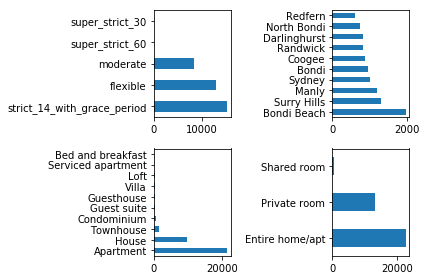

In [21]:
# plot most common features such as type of cancellation policy, location, room type and property type
plt.subplot(2, 2, 1)
df["cancellation_policy"].value_counts().plot(kind='barh')

plt.subplot(2, 2, 2)
df["city"].value_counts()[:10].plot(kind='barh')

plt.subplot(2, 2, 3)
df["property_type"].value_counts()[:10].plot(kind='barh')

plt.subplot(2, 2, 4)
df["room_type"].value_counts()[:10].plot(kind='barh')

plt.tight_layout()

We can see the most common features are: cancelation policy with 14 day grace period; city of Bondi beach; property type is apartment; and, room type is entire home/apartment

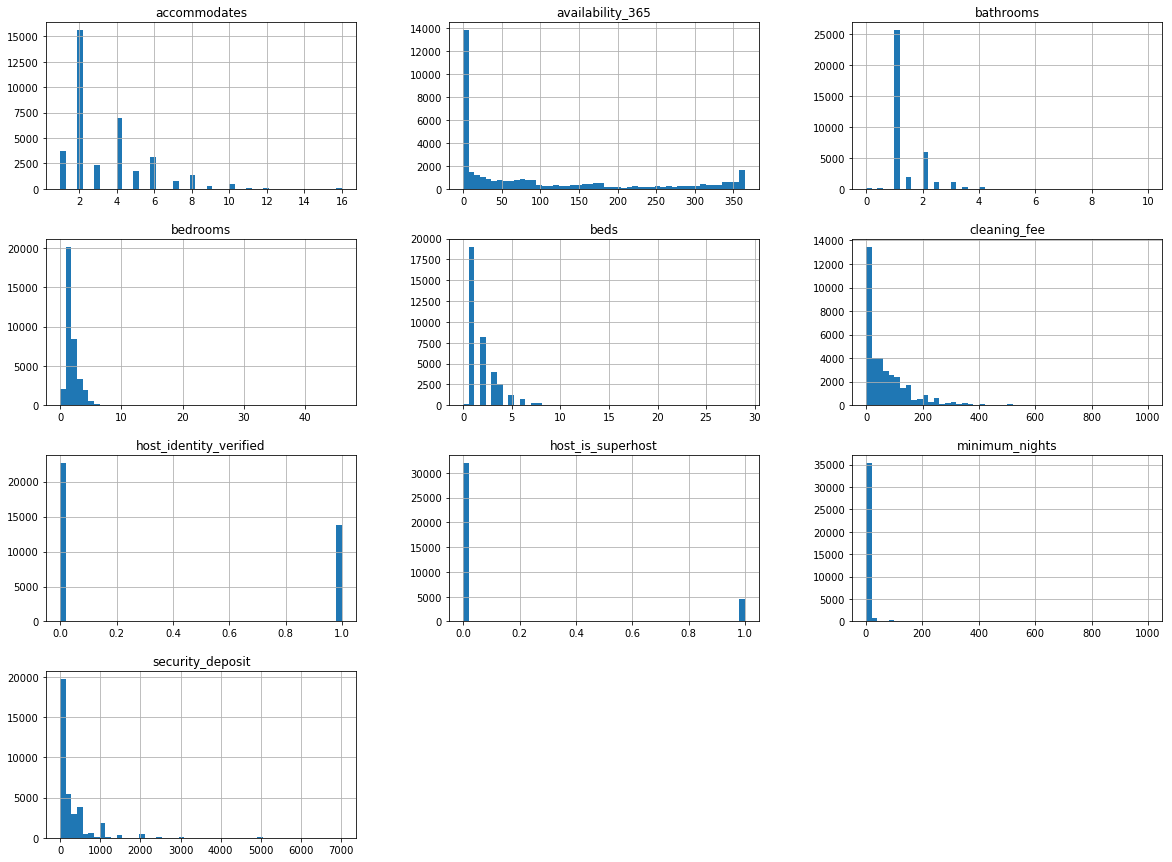

In [22]:
# Visualise distribution of data such as number of people, bathrooms, beds, etc. 
df.iloc[:,6:].hist(bins=50, figsize=(20,15))
plt.show()

# Split data for training and testing

In [23]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_of_top_20_reduced, test_size=0.2, random_state=42)

### Stratified Shuffle Split cross-validator

Provides train/test indices to split data in train/test sets.

This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

## Stratify according to city
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_of_top_20_reduced, df_of_top_20_reduced["city_code"]):
    del df_of_top_20_reduced["city_code"]
    strat_train_set = df_of_top_20_reduced.loc[train_index]
    strat_test_set = df_of_top_20_reduced.loc[test_index]

In [25]:
## Average price per area
strat_test_set.groupby("city")["price"].mean()

city
Bondi           174.375000
Bondi Beach     192.538265
Coogee          200.092486
Darlinghurst    166.987654
Manly           240.436975
North Bondi     222.722973
Randwick        161.406061
Redfern         131.024590
Surry Hills     163.513514
Sydney          210.935961
Name: price, dtype: float64

# Further Data Exploration and Visualization

#### Plot smaller area and prices under $600

In [26]:
traval = strat_train_set.copy() ##traval - training and validation set

In [27]:
# narrow area
traval_co = traval[(traval["longitude"]>151.16)&(traval["latitude"]<-33.75)].reset_index(drop=True)
traval_co = traval_co[traval_co["latitude"]>-33.95].reset_index(drop=True)

# locations under $600
traval_co = traval_co[traval_co["price"]<600].reset_index(drop=True)

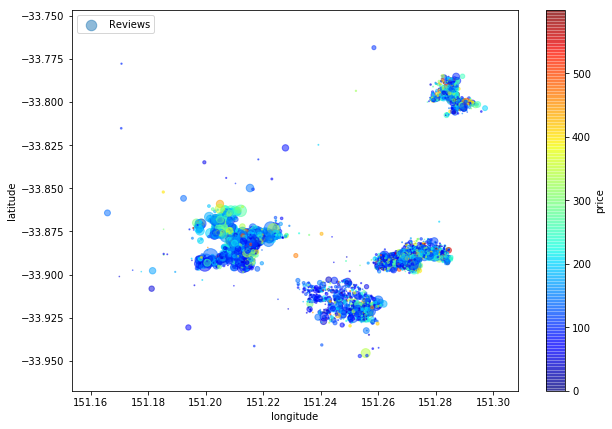

In [28]:
#basic scatter plot
traval_co.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
    s=traval_co["number_of_reviews"]/2, label="Reviews", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [29]:
# plot with mapbox
import plotly.express as px
px.set_mapbox_access_token("pk.eyJ1IjoibWF0dC1kYWxlIiwiYSI6ImNremUxeHZ0ZDBlMzAzMW1xdmp2endycjYifQ.K4vhZbawEgntbdvgCxRVsQ")
px.scatter_mapbox(traval_co, lat="latitude", lon="longitude",color="price", size="number_of_reviews",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=20,zoom=10)


#### Plot correlation matrix

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

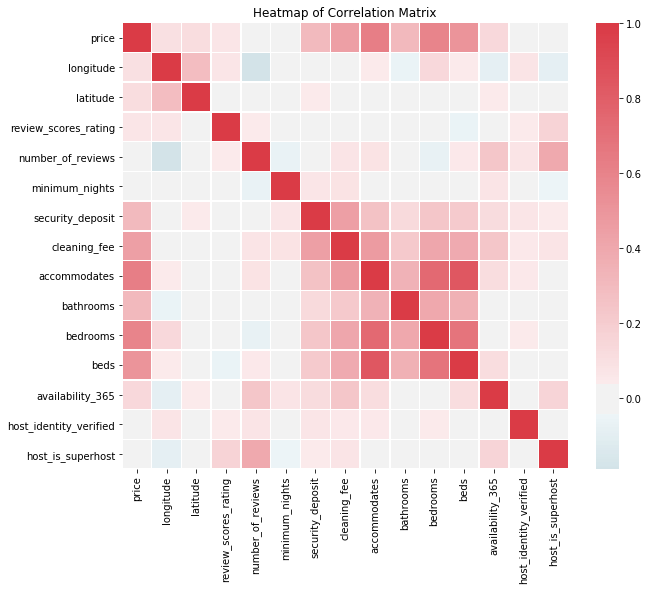

In [30]:
# get correlation
corr_matrix = traval_co.corr()

# Heatmap
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220,10,as_cmap = True)
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns.values,
           yticklabels=corr_matrix.columns.values, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

In [31]:
# What is most correlated to price?
corr_matrix["price"].sort_values(ascending=False)

price                     1.000000
accommodates              0.633133
bedrooms                  0.598315
beds                      0.515660
cleaning_fee              0.451889
bathrooms                 0.312227
security_deposit          0.301182
availability_365          0.134944
latitude                  0.110348
longitude                 0.095722
review_scores_rating      0.064310
host_identity_verified    0.038270
host_is_superhost         0.033645
minimum_nights            0.019992
number_of_reviews        -0.017317
Name: price, dtype: float64

D:\Anaconda\envs\pytorchenv\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

D:\Anaconda\envs\pytorchenv\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



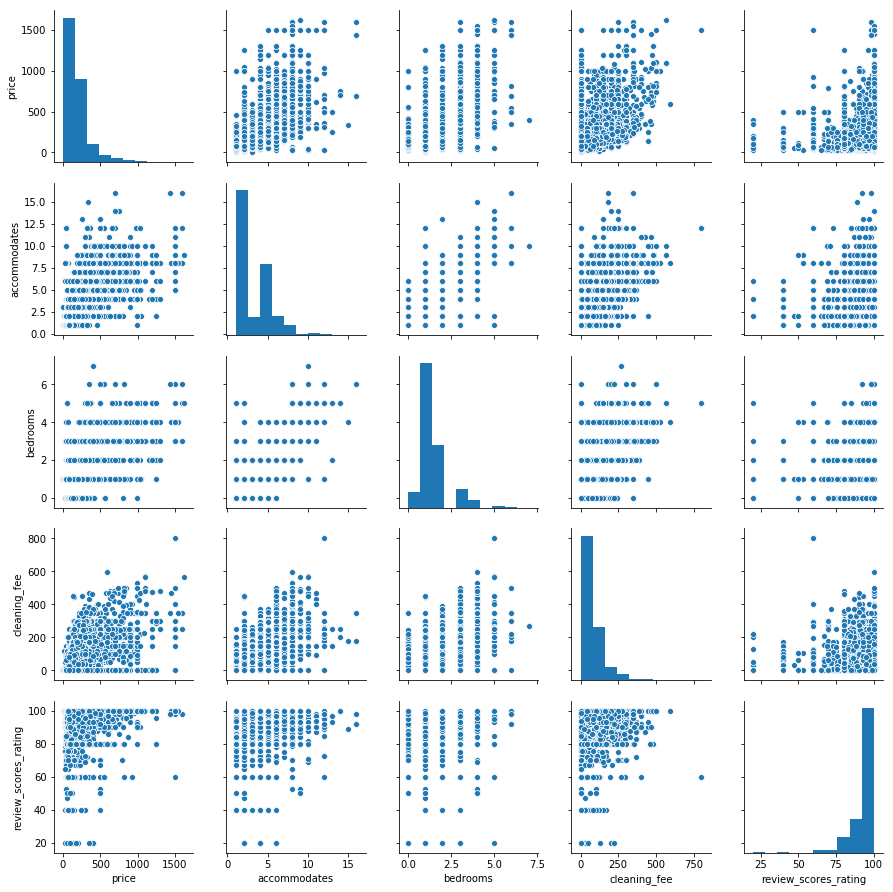

In [32]:
# plot correlation
attributes = ["price", "accommodates", "bedrooms",
              "cleaning_fee","review_scores_rating","property_type"]

sns.pairplot(traval[attributes])

# Prepare the data for Machine Learning algorithms

In [33]:
# Remove our price (or labels from our travel dataset)
X  = strat_train_set.copy().drop("price", axis=1) # drop labels for training set

#### Create a **pipeline** for preprocessing that: creates **new features**, uses **Imputer** to fill in missing data, **one-hot encoding** of categorical features, and **feature scaling** using StandardScaler .

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import itertools

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Receive numpy array, convert to pandas for features, convert back to array for output.
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, popularity = True, num_cols=[]): # no *args or **kargs
        self.popularity = popularity
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        
        ### Some feature engineering
        X = pd.DataFrame(X, columns=num_cols)
        X["bedrooms_per_person"] = X["bedrooms"]/X["accommodates"]
        X["bathrooms_per_person"] = X["bathrooms"]/X["accommodates"]
        
        global feats
        feats = ["bedrooms_per_person","bathrooms_per_person"]

        if self.popularity:
            X["past_and_future_popularity"]=X["number_of_reviews"]/(X["availability_365"]+1)
            feats.append("past_and_future_popularity")
            
            return X.values
        else:
            return X.values

In [35]:
# 
strat_train_set2 = strat_train_set.dropna()
X = strat_train_set2.copy().drop("price",axis=1)
Y = strat_train_set2["price"]

num_cols = list(X.select_dtypes(include=numerics).columns)
cat_cols = list(X.select_dtypes(include=[object]).columns)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder(num_cols=num_cols,popularity=True)),
        ('std_scaler', StandardScaler()),
    ])

In [36]:
mid_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", OneHotEncoder(),cat_cols),
    ])

In [37]:
mid_pipeline.fit(X) # this one specifically has to be fitted for the cat names
cat_encoder = mid_pipeline.named_transformers_["cat"]

sublists = [list(bas) for bas in cat_encoder.categories_]
one_cols = list(itertools.chain(*sublists))

In [38]:
## In this class, I will be converting numpy back to pandas
class ToPandasDF(BaseEstimator, TransformerMixin):
    def __init__(self, fit_index = [] ): # no *args or **kargs
        self.fit_index = fit_index
    def fit(self, X_df, y=None):
        return self  # nothing else to do
    def transform(self, X_df, y=None):
        global cols
        cols = num_cols.copy()
        cols.extend(feats)
        cols.extend(one_cols) # one in place of cat
        X_df = pd.DataFrame(X_df, columns=cols,index=self.fit_index)

        return X_df

def pipe(inds):
    return Pipeline([
            ("mid", mid_pipeline),
            ("PD", ToPandasDF(inds)),
        ])

In [39]:
params = {"inds" : list(X.index)}

X_pr = pipe(**params).fit_transform(X) # The pipeline does all the preprocessing and outputs pandas dataframe
X_pr.head()

longitude  latitude  review_scores_rating  number_of_reviews  \
6238   0.854814 -0.378634              0.387631           0.351503   
1181   1.168249 -0.205737              0.700265          -0.522245   
6114   0.580829 -0.419639              0.700265          -0.283950   
4469   1.013449  0.003746             -0.341848          -0.416336   
950   -0.976820 -0.246214              0.283420           4.508427   

      minimum_nights  security_deposit  cleaning_fee  accommodates  bathrooms  \
6238       -0.148589         -0.178255      0.914954     -0.670383  -0.453998   
1181       -0.094765         -0.590126     -0.303534     -0.670383  -0.453998   
6114       -0.094765         -0.590126     -0.988078     -0.670383  -0.453998   
4469       -0.148589         -0.590126     -0.988078     -1.210413   0.509872   
950        -0.202412         -0.590126     -0.988078     -0.670383   1.473742   

      bedrooms      beds  availability_365  host_identity_verified  \
6238 -0.488109 -0.643612         -0.172233                1.025488   
1181 -0.488109 -0.643612         -0.765492                1.025488   
6114 -0.488109 -0.643612         -0.481759               -0.975146   
4469 -0.488109 -0.643612         -0.765492                1.025488   
950  -0.488109 -0.643612         -0.258213                1.025488   

      host_is_superhost  bedrooms_per_person  bathrooms_per_person  \
6238           2.378304             0.100288              0.094841   
1181          -0.420468             0.100288              0.094841   
6114          -0.420468             0.100288              0.094841   
4469          -0.420468             2.195029              3.491003   
950            2.378304             0.100288              1.792922   

      past_and_future_popularity  Bondi  Bondi Beach  Coogee  Darlinghurst  \
6238                   -0.268123    0.0          1.0     0.0           0.0   
1181                   -0.210194    0.0          0.0     0.0           0.0   
6114                   -0.289704    1.0          0.0     0.0           0.0   
4469                    0.240361    0.0          0.0     0.0           0.0   
950                     0.035734    0.0          0.0     0.0           0.0   

      Manly  North Bondi  Randwick  Redfern  Surry Hills  Sydney  Apartment  \
6238    0.0          0.0       0.0      0.0          0.0     0.0        1.0   
1181    0.0          1.0       0.0      0.0          0.0     0.0        1.0   
6114    0.0          0.0       0.0      0.0          0.0     0.0        1.0   
4469    0.0          1.0       0.0      0.0          0.0     0.0        1.0   
950     0.0          0.0       0.0      0.0          1.0     0.0        0.0   

      Bed and breakfast  Boutique hotel  Bungalow  Condominium  Cottage  \
6238                0.0             0.0       0.0          0.0      0.0   
1181                0.0             0.0       0.0          0.0      0.0   
6114                0.0             0.0       0.0          0.0      0.0   
4469                0.0             0.0       0.0          0.0      0.0   
950                 0.0             0.0       0.0          0.0      0.0   

      Guest suite  Guesthouse  Hostel  Hotel  House  Loft  Other  \
6238          0.0         0.0     0.0    0.0    0.0   0.0    0.0   
1181          0.0         0.0     0.0    0.0    0.0   0.0    0.0   
6114          0.0         0.0     0.0    0.0    0.0   0.0    0.0   
4469          0.0         0.0     0.0    0.0    0.0   0.0    0.0   
950           0.0         0.0     0.0    0.0    1.0   0.0    0.0   

      Serviced apartment  Townhouse  Villa  Entire home/apt  Private room  \
6238                 0.0        0.0    0.0              1.0           0.0   
1181                 0.0        0.0    0.0              0.0           1.0   
6114                 0.0        0.0    0.0              0.0           1.0   
4469                 0.0        0.0    0.0              0.0           1.0   
950                  0.0        0.0    0.0              0.0        

# Select and train a model 

In [188]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

#### Random forest regressor

In [160]:
def random_forest_model(X, Y):

    param_grid = {'n_estimators': [3, 10, 30], 
                  'max_features': [2, 4, 6, 8]}
      
    estimator = RandomForestRegressor()

    rscv = RandomizedSearchCV(
        estimator,
        param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    

    grid_result = rscv.fit(X, Y)

    best_params = grid_result.best_params_
    
    best_model = RandomForestRegressor(n_estimators=best_params["n_estimators"],
                                       max_features=best_params["max_features"])

    scoring = {'abs_error': 'neg_mean_absolute_error',
               'squared_error': 'neg_mean_squared_error',
               'r2':'r2'}

    scores = cross_validate(best_model, X, Y, cv=10, scoring=scoring, return_train_score=True, return_estimator = True)

    return scores, best_model

#### Gradient boosting regressor

In [189]:
def gb_model(X, Y):

    param_grid = {'n_estimators': [50, 100, 200],
                  'learning_rate': [0.001, 0.1],
                  'max_features': ['auto', 'sqrt', 'log2']}
      
    estimator = GradientBoostingRegressor()

    rscv = RandomizedSearchCV(
        estimator,
        param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    

    grid_result = rscv.fit(X, Y)

    best_params = grid_result.best_params_
    
    best_model = RandomForestRegressor(n_estimators=best_params["n_estimators"],
                                       max_features=best_params["max_features"])

    scoring = {'abs_error': 'neg_mean_absolute_error',
               'squared_error': 'neg_mean_squared_error',
               'r2':'r2'}

    scores = cross_validate(best_model, X, Y, cv=10, scoring=scoring, return_train_score=True, return_estimator = True)

    return scores, best_model

#### MLP regressor model

In [228]:
def mlp_model(X, Y):

    estimator = MLPRegressor()

    param_grid = {'hidden_layer_sizes': [(50,1),(100,1),(50,25)],
              'activation': ['relu','tanh'],
              'alpha': [0.0001, 0.05],
              'learning_rate': ['adaptive'],
              'solver': ['adam'],
              'max_iter': [1000],
              'random_state':[0]}

    rscv = RandomizedSearchCV(
        estimator,
        param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = rscv.fit(X, Y)

    best_params = grid_result.best_params_

    best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"], 
                            activation =best_params["activation"],
                            solver=best_params["solver"],
                            alpha=best_params["alpha"],
                            learning_rate= best_params["learning_rate"],
                            max_iter= 3000, n_iter_no_change = 200, random_state=0
                  )

    scoring = {'abs_error': 'neg_mean_absolute_error',
               'squared_error': 'neg_mean_squared_error',
               'r2':'r2'}

    scores = cross_validate(best_mlp, X, Y, cv=10, scoring=scoring, return_train_score=True, return_estimator = True)

    return scores, best_model

#### Prepare test set to evaluate models

In [183]:
# prepare test set
test_set = strat_test_set.dropna()
X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()

X_test_prepared = pipe(list(X_test.index)).transform(X_test)

In [190]:
# find best params for gradient boosting model
scores, best_gbmodel = gb_model(X_pr, Y_pr)

gbmodel = best_gbmodel.fit(X_pr, Y_pr)

print('Train mean absolute error:', scores['train_abs_error'])

y_gb_pred = gbmodel.predict(X_test_prepared)
print('Model score:', gbmodel.score(X_test_prepared, y_test))   

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_gb_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_gb_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_gb_pred)))

Train mean absolute error: [-20.31446976 -20.2295029  -20.36725352 -20.35975766 -20.04425021
 -20.20193208 -20.06484987 -20.48504866 -20.71111617 -20.68871816]
Model score: 0.5975846398953188
Mean Absolute Error: 52.83731054977711
Mean Squared Error: 8832.192596136701
Root Mean Squared Error: 93.97974566967449


In [191]:
# find best params for random forest model
scores, best_rfmodel = random_forest_model(X_pr, Y_pr)

rfmodel = best_rfmodel.fit(X_pr, Y_pr)

print('Train mean absolute error:', scores['train_abs_error'])

y_rf_pred = rfmodel.predict(X_test_prepared)
print('Model score:', rfmodel.score(X_test_prepared, y_test)) 

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_rf_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_rf_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_rf_pred)))

Train mean absolute error: [-20.47677437 -20.84148025 -20.3976802  -20.37290804 -20.52617785
 -20.21640781 -20.14435701 -20.78357148 -20.82177815 -20.67602678]
Model score: 0.5927279564731976
Mean Absolute Error: 53.43583457157008
Mean Squared Error: 8938.786845798251
Root Mean Squared Error: 94.54515770677128


In [229]:
# find best params for mlp model
scores, best_mlpmodel = mlp_model(X_pr, Y_pr)

mlpmodel = best_mlpmodel.fit(X_pr, Y_pr)

print('Train mean absolute error:', scores['train_abs_error'])

y_mlp_pred = mlpmodel.predict(X_test_prepared)
print('Model score:', mlpmodel.score(X_test_prepared, y_test))   

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_mlp_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_mlp_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_mlp_pred)))

D:\Anaconda\envs\pytorchenv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

D:\Anaconda\envs\pytorchenv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.

D:\Anaconda\envs\pytorchenv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.

D:\Anaconda\envs\pytorchenv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.

D:\Anaconda\envs\pytorchenv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:



Train mean absolute error: [ -49.80910814 -117.70922959 -119.65348447 -118.44977455 -118.18685017
  -43.14377344 -117.56162703  -42.66370677  -43.82535527  -43.75813397]
Model score: 0.5988744332233444
Mean Absolute Error: 52.7482334489021
Mean Squared Error: 8803.884275402199
Root Mean Squared Error: 93.8290161698512


In [215]:
# define final model to use
final_model = gbmodel

## Value Estimation for Client

Create customer infomation

In [70]:
from dateutil import parser
dict_client = {}

dict_client["city"] = "Bondi Beach"
dict_client["longitude"] = 151.274506
dict_client["latitude"] = -33.889087
dict_client["review_scores_rating"] = 95
dict_client["number_of_reviews"] = 53
dict_client["minimum_nights"] = 4
dict_client["security_deposit"] = 1500
dict_client["cleaning_fee"] = 370
dict_client["accommodates"] = 10
dict_client["bathrooms"] = 3
dict_client["bedrooms"] = 5
dict_client["beds"] = 7
dict_client["property_type"] = "House"
dict_client["room_type"] = "Entire home/apt"
dict_client["availability_365"] = 255
dict_client["host_identity_verified"] = '1'  ## 1 for yes, 0 for no
dict_client["host_is_superhost"] = '1'
dict_client["host_since"] = parser.parse("01-08-2010")
dict_client["cancellation_policy"] = "strict_14_with_grace_period"

df_client = pd.DataFrame.from_dict(dict_client, orient='index').T

print(df_client.columns)
df_client

Index(['city', 'longitude', 'latitude', 'review_scores_rating',
       'number_of_reviews', 'minimum_nights', 'security_deposit',
       'cleaning_fee', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'property_type', 'room_type', 'availability_365',
       'host_identity_verified', 'host_is_superhost', 'host_since',
       'cancellation_policy'],
      dtype='object')


city longitude latitude review_scores_rating number_of_reviews  \
0  Bondi Beach   151.275 -33.8891                   95                53   

  minimum_nights security_deposit cleaning_fee accommodates bathrooms  \
0              4             1500          370           10         3   

  bedrooms beds property_type        room_type availability_365  \
0        5    7         House  Entire home/apt              255   

  host_identity_verified host_is_superhost           host_since  \
0                      1                 1  2010-01-08 00:00:00   

           cancellation_policy  
0  strict_14_with_grace_period

In [71]:
df_client = pd.DataFrame.from_dict(dict_client, orient='index').T
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 19 columns):
city                      1 non-null object
longitude                 1 non-null object
latitude                  1 non-null object
review_scores_rating      1 non-null object
number_of_reviews         1 non-null object
minimum_nights            1 non-null object
security_deposit          1 non-null object
cleaning_fee              1 non-null object
accommodates              1 non-null object
bathrooms                 1 non-null object
bedrooms                  1 non-null object
beds                      1 non-null object
property_type             1 non-null object
room_type                 1 non-null object
availability_365          1 non-null object
host_identity_verified    1 non-null object
host_is_superhost         1 non-null object
host_since                1 non-null object
cancellation_policy       1 non-null object
dtypes: object(19)
memory usage: 232.0+ bytes


In [72]:
df_client.iloc[0]

city                                      Bondi Beach
longitude                                     151.275
latitude                                     -33.8891
review_scores_rating                               95
number_of_reviews                                  53
minimum_nights                                      4
security_deposit                                 1500
cleaning_fee                                      370
accommodates                                       10
bathrooms                                           3
bedrooms                                            5
beds                                                7
property_type                                   House
room_type                             Entire home/apt
availability_365                                  255
host_identity_verified                              1
host_is_superhost                                   1
host_since                        2010-01-08 00:00:00
cancellation_policy       st

In [73]:
df_client = pipe(list(df_client.index)).transform(df_client)

In [74]:
df_client

longitude  latitude  review_scores_rating  number_of_reviews  \
0   0.920921 -0.278901              0.179209            0.85457   

   minimum_nights  security_deposit  cleaning_fee  accommodates  bathrooms  \
0       -0.040942          2.498902      4.077547      3.649861   3.401483   

   bedrooms      beds  availability_365  host_identity_verified  \
0  4.120258  3.917784          1.426986                1.025488   

   host_is_superhost  bedrooms_per_person  bathrooms_per_person  \
0           2.378304             0.100288             -0.584391   

   past_and_future_popularity  Bondi  Bondi Beach  Coogee  Darlinghurst  \
0                   -0.299513    0.0          1.0     0.0           0.0   

   Manly  North Bondi  Randwick  Redfern  Surry Hills  Sydney  Apartment  \
0    0.0          0.0       0.0      0.0          0.0     0.0        0.0   

   Bed and breakfast  Boutique hotel  Bungalow  Condominium  Cottage  \
0                0.0             0.0       0.0          0.0      0.0   

   Guest suite  Guesthouse  Hostel  Hotel  House  Loft  Other  \
0          0.0         0.0     0.0    0.0    1.0   0.0    0.0   

   Serviced apartment  Townhouse  Villa  Entire home/apt  Private room  \
0                 0.0        0.0    0.0              1.0           0.0   

   Shared room  flexible  moderate  strict_14_with_grace_period  \
0          0.0       0.0       0.0                          1.0   

   super_strict_30  super_strict_60  
0              0.0              0.0

In [199]:
client_pred = final_model.predict(df_client)

In [216]:
print('\x1b[1;31m'+str(client_pred[0])+'\x1b[0m')
print('\x1b[1;31m'+str(-500)+'\x1b[0m')
print('\x1b[1;31m'+"= "+str(client_pred[0]-500)+'\x1b[0m')

938.9666666666667
-500
= 438.9666666666667


### Client should be charging a lot more.... 